In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm
import os

%matplotlib notebook

## constants

In [2]:
DATA_PATH = "data"
TRAIN_VIDEO =  os.path.join(DATA_PATH,"train.mp4")
TEST_VIDEO = os.path.join(DATA_PATH,"test.mp4")
TRAIN_SPEED_TXT = os.path.join(DATA_PATH,"train.txt")

TRAIN_FRAMES_DIR = "frames/train_mp4/"
TEST_FRAMES_DIR = "frames/test_mp4/"

CLEAN_DATA = "clean_data"
CLEAN_TRAIN_IMG = os.path.join(CLEAN_DATA,"train_imgs")
CLEAN_TEST_IMG = os.path.join(CLEAN_DATA,"test_imgs")


FPS = 20
train_frames = 20400
test_frames = 10798


### functions

In [3]:
def multiple_imshow(df, frame_range):
    for i in range(frame_range[0],frame_range[1]):
        print("speed: ", df["speed"][i])
        img=mpimg.imread(df["img_path"][i])
        print("shape: ", img.shape)
        plt.axis("off")
        plt.imshow(img)
        plt.show()

In [7]:
vid = cv2.VideoCapture("data/train.mp4")
cv_cap_props = [cv2.CAP_PROP_POS_MSEC,
cv2.CAP_PROP_POS_FRAMES,
cv2.CAP_PROP_POS_AVI_RATIO,
cv2.CAP_PROP_FRAME_WIDTH,
cv2.CAP_PROP_FRAME_HEIGHT,
cv2.CAP_PROP_FPS,
cv2.CAP_PROP_FOURCC,
cv2.CAP_PROP_FRAME_COUNT,
cv2.CAP_PROP_FORMAT,
cv2.CAP_PROP_MODE,
cv2.CAP_PROP_BRIGHTNESS,
cv2.CAP_PROP_CONTRAST,
cv2.CAP_PROP_SATURATION,
cv2.CAP_PROP_HUE,
cv2.CAP_PROP_GAIN,
cv2.CAP_PROP_EXPOSURE,
cv2.CAP_PROP_CONVERT_RGB,
#cv2.CAP_PROP_WHITE_BALANCE_U,
#cv2.CAP_PROP_WHITE_BALANCE_V,
cv2.CAP_PROP_RECTIFICATION,
cv2.CAP_PROP_ISO_SPEED,
cv2.CAP_PROP_BUFFERSIZE]
for p in cv_cap_props:
    print(vid.get(p),p)

0.0 0
0.0 1
9.765625e-05 2
640.0 3
480.0 4
20.0 5
828601953.0 6
20400.0 7
0.0 8
0.0 9
0.0 10
0.0 11
0.0 12
0.0 13
0.0 14
0.0 15
0.0 16
0.0 18
0.0 30
0.0 38


## splitting up train/test videos into frames

In [4]:
def toframes(dataset_type):
    if "train" in  dataset_type:
        outdir = "frames/train_mp4/"
    elif "test" in dataset_type:
        outdir = "frames/test_mp4/"
    
    vid = cv2.VideoCapture(os.path.join(DATA_PATH,dataset_type+".mp4"))
    success,img = vid.read()
    count = 0
    while success:
        cv2.imwrite(outdir+"frame%d.jpg"%count, img)
        success, img = vid.read()
        if count % 100 == 0:
            print("reading a new frame: ", count)
        count += 1
    print("done")

In [27]:
toframes("train")
toframes("test")

reading a new frame:  0
reading a new frame:  100
reading a new frame:  200
reading a new frame:  300
reading a new frame:  400
reading a new frame:  500
reading a new frame:  600
reading a new frame:  700
reading a new frame:  800
reading a new frame:  900
reading a new frame:  1000
reading a new frame:  1100
reading a new frame:  1200
reading a new frame:  1300
reading a new frame:  1400
reading a new frame:  1500
reading a new frame:  1600
reading a new frame:  1700
reading a new frame:  1800
reading a new frame:  1900
reading a new frame:  2000
reading a new frame:  2100
reading a new frame:  2200
reading a new frame:  2300
reading a new frame:  2400
reading a new frame:  2500
reading a new frame:  2600
reading a new frame:  2700
reading a new frame:  2800
reading a new frame:  2900
reading a new frame:  3000
reading a new frame:  3100
reading a new frame:  3200
reading a new frame:  3300
reading a new frame:  3400
reading a new frame:  3500
reading a new frame:  3600
reading a new

In [ ]:
cv2.Vide

## plotting image/frames

In [5]:
def frameshow_matplot(frame_n,dir_name = "frames/train_mp4/"):
    if not isinstance(frame_n,list):
        frame_n = [frame_n]
    
    for fn in frame_n:
        img = mpimg.imread(f"frames/train_mp4/frame{fn}.jpg")
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.axis("off")
        plt.imshow(img)
        plt.show()

In [12]:
img = mpimg.imread("frames/train_mp4/frame0.jpg")
plt.show(img)
#plt.show()

## Create Dataset

In [7]:
train_y = list(pd.read_csv(os.path.join(DATA_PATH,"train.txt"),header=None,squeeze=True))
print(len(train_y),len(os.listdir(TRAIN_FRAMES_DIR)))

20400 20400


In [16]:
def dataset_generator(video_loc, output_dir, dataset_type, Y, n_frames=[train_frames,test_frames]):
    meta_dict = {}
    
    if dataset_type == "train":
        n_frames = n_frames[0]
    elif dataset_type == "test":
        n_frames = n_frames[1]
        
    count = 0
    vid = cv2.VideoCapture(video_loc)
    pbar = tqdm(total=int(vid.get(cv2.CAP_PROP_FRAME_COUNT)), desc="reading video...",initial=1)
    success,img = vid.read()
    
    while success:
        img_path = os.path.join(output_dir,f"frame{count}.jpg")
        cv2.imwrite(img_path,img) #write image
        
        frame_speed = float("NaN") if dataset_type == "test" else Y[count]
        meta_dict[count] = [img_path,count,frame_speed]
        
        # next frame
        success, img = vid.read()
        count+=1
        pbar.update(1)
        
    meta_df = pd.DataFrame.from_dict(meta_dict,orient="index")
    meta_df.columns = ["img_path","img_index","speed"]
    meta_df.to_csv( os.path.join(CLEAN_DATA, dataset_type+"_meta.csv"), index=False )
    return meta_df

In [17]:
# train data
train_meta = dataset_generator(TRAIN_VIDEO,CLEAN_TRAIN_IMG,"train",train_y)

In [18]:
# test data
dataset_generator(TEST_VIDEO,CLEAN_TEST_IMG,"test",train_y)

,img_path,img_index,speed
0,clean_data\test_imgs\frame0.jpg,0,NaN
1,clean_data\test_imgs\frame1.jpg,1,NaN
2,clean_data\test_imgs\frame2.jpg,2,NaN
3,clean_data\test_imgs\frame3.jpg,3,NaN
4,clean_data\test_imgs\frame4.jpg,4,NaN
...,...,...,...
10793,clean_data\test_imgs\frame10793.jpg,10793,NaN
10794,clean_data\test_imgs\frame10794.jpg,10794,NaN
10795,clean_data\test_imgs\frame10795.jpg,10795,NaN
10796,clean_data\test_imgs\frame10796.jpg,10796,NaN


In [27]:
train_meta = pd.read_csv(os.path.join(CLEAN_DATA,"train_meta.csv"))
test_meta = pd.read_csv(os.path.join(CLEAN_DATA,"test_meta.csv"))

### Train

In [28]:
assert(train_meta.shape[0] == train_frames)
assert(train_meta.shape[1] == 3)

In [29]:
train_meta.head()

,img_path,img_index,speed
0,clean_data\train_imgs\frame0.jpg,0,28.105569
1,clean_data\train_imgs\frame1.jpg,1,28.105569
2,clean_data\train_imgs\frame2.jpg,2,28.106527
3,clean_data\train_imgs\frame3.jpg,3,28.130404
4,clean_data\train_imgs\frame4.jpg,4,28.109243


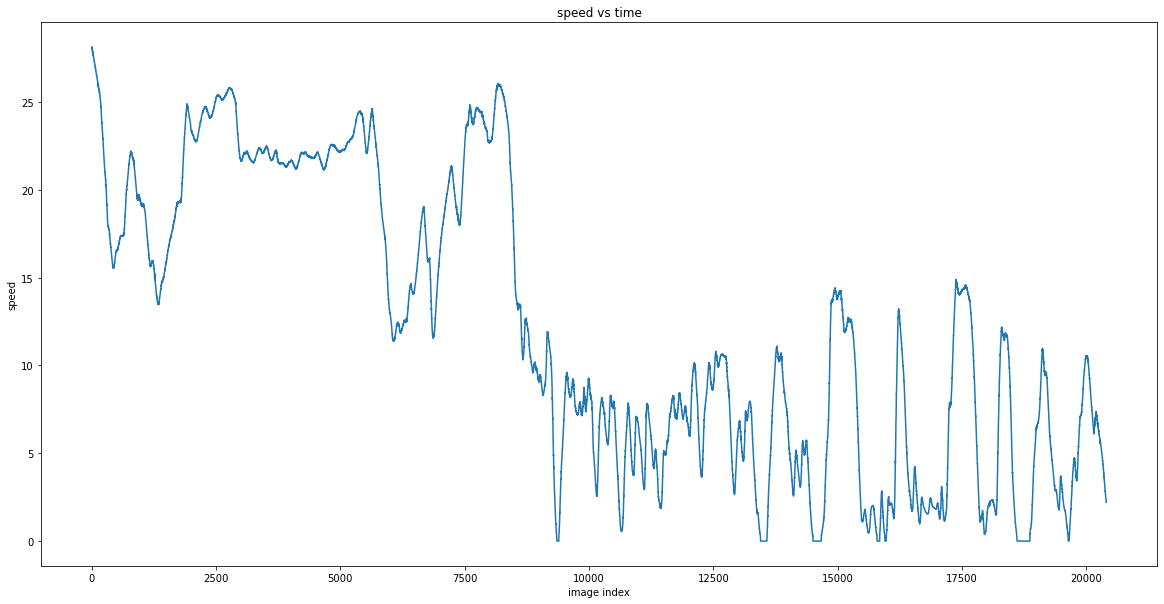

In [26]:
# plot speed vs time
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_meta["speed"])
plt.xlabel("image index")
plt.ylabel("speed")
plt.title("speed vs time")
plt.show()

speed:  28.105569
shape:  (480, 640, 3)


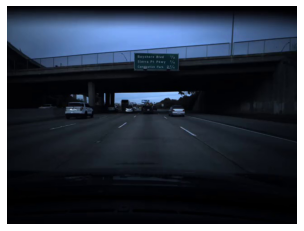

speed:  28.105569
shape:  (480, 640, 3)


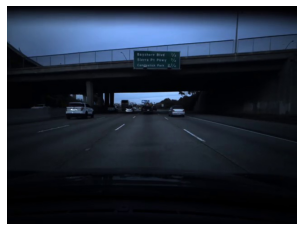

speed:  28.106527000000003
shape:  (480, 640, 3)


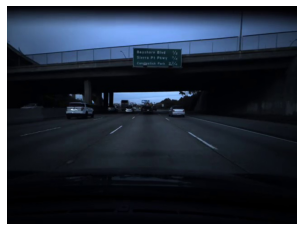

speed:  28.130404
shape:  (480, 640, 3)


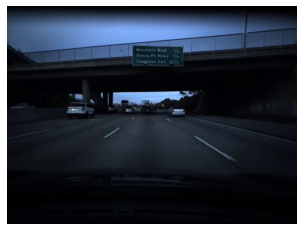

speed:  28.109243
shape:  (480, 640, 3)


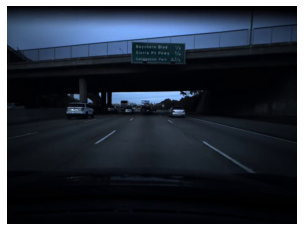

speed:  28.088572
shape:  (480, 640, 3)


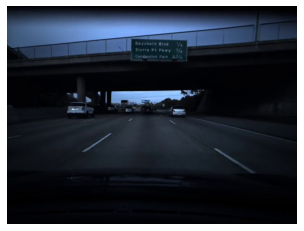

speed:  28.034211
shape:  (480, 640, 3)


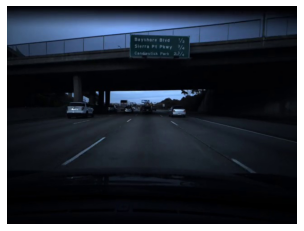

speed:  28.018491
shape:  (480, 640, 3)


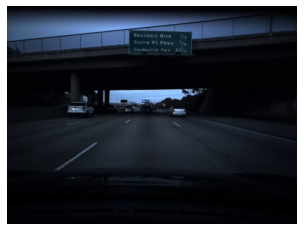

speed:  27.986624
shape:  (480, 640, 3)


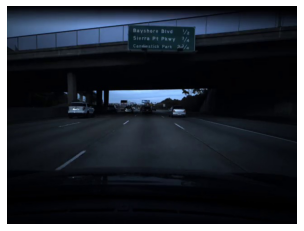

speed:  28.016352
shape:  (480, 640, 3)


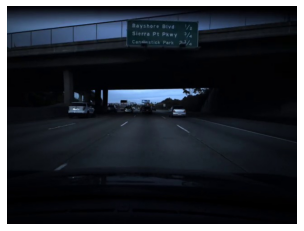

In [32]:
multiple_imshow(train_meta,[0,10])

### test

In [33]:
assert test_meta.shape[0] == test_frames
assert test_meta.shape[1] == 3

In [34]:
test_meta.head()

,img_path,img_index,speed
0,clean_data\test_imgs\frame0.jpg,0,NaN
1,clean_data\test_imgs\frame1.jpg,1,NaN
2,clean_data\test_imgs\frame2.jpg,2,NaN
3,clean_data\test_imgs\frame3.jpg,3,NaN
4,clean_data\test_imgs\frame4.jpg,4,NaN


speed:  nan
shape:  (480, 640, 3)


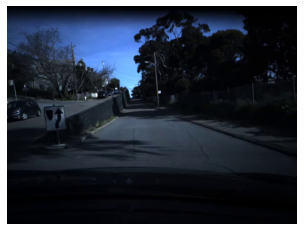

speed:  nan
shape:  (480, 640, 3)


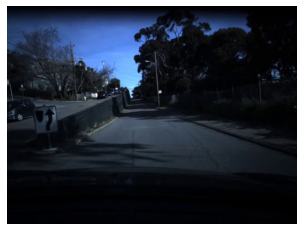

speed:  nan
shape:  (480, 640, 3)


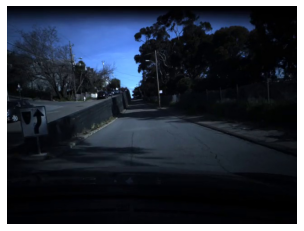

speed:  nan
shape:  (480, 640, 3)


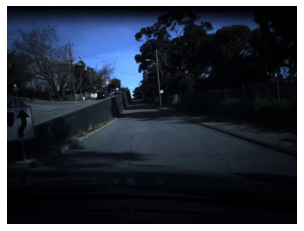

speed:  nan
shape:  (480, 640, 3)


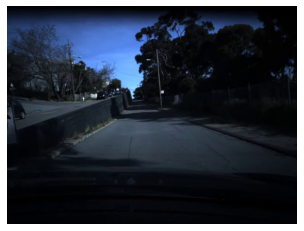

speed:  nan
shape:  (480, 640, 3)


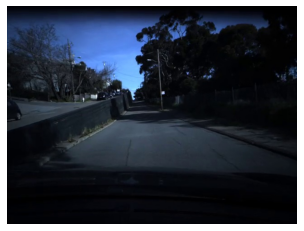

speed:  nan
shape:  (480, 640, 3)


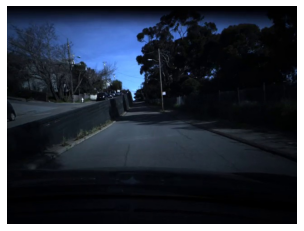

speed:  nan
shape:  (480, 640, 3)


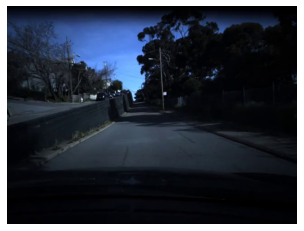

speed:  nan
shape:  (480, 640, 3)


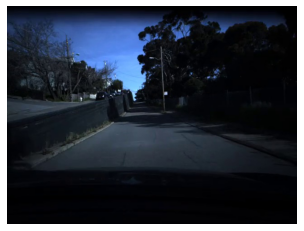

speed:  nan
shape:  (480, 640, 3)


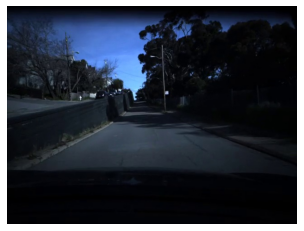

In [35]:
multiple_imshow(test_meta,[0,10])

## Properties of input video that need to be accounted for

<ul>
    <li>Illumination Changes</li>
    <ul>
        <li>Caused by changes in lighting that affects objects in successive frames.</li>
    </ul>
    <li>Scale Changes</li>
    <ul>
        <li>Caused by object size changes as camera perspective move through space.</li>
    </ul>
    <li>Repetitive Structures</li>
    <ul>
        <li>Objects which repetitively appear on the scene but do not change over time.</li>
    </ul>
</ul>
    

## Preprocessing

In [58]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    img[:,:,2] = img[:,:,2]*bright_factor
    img = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    return img
    

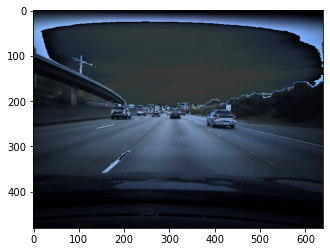

In [79]:
img = cv2.imread("frames/train_mp4/frame60.jpg")
plt.imshow(change_brightness(img,1.23))

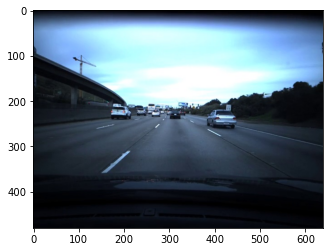

In [80]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [51]:
hsv[0].shape

(640, 3)

In [52]:
hsv.shape

(480, 640, 3)

array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [5, 5, 5, ..., 0, 0, 0],
       ...,
       [4, 4, 4, ..., 5, 5, 5],
       [4, 4, 4, ..., 5, 5, 5],
       [4, 4, 4, ..., 5, 5, 5]], dtype=uint8)

## Generate Train Dataset

In [28]:
train_y = list(pd.read_csv(TRAIN_SPEED_TXT,header=None,squeeze=True))

In [29]:
print(len(train_y), train_frames)

20400 20400
